### Imports

In [1]:
!pip install -r requirements.txt    

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 131.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 43.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 102.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 132.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 141.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 28.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 129.1 MB/s eta 0:00:00
  

In [1]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, \
WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize,\
ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep

### Data generation

In [2]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

In [6]:
images.shape

(300, 1, 5, 5)

In [7]:
images[1:3]

array([[[[  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0, 255]]],


       [[[  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0],
         [  0,   0,   0,   0, 255]]]], dtype=uint8)

In [8]:
example = images[7]
example,example.shape

(array([[[  0, 255,   0,   0,   0],
         [  0,   0, 255,   0,   0],
         [  0,   0,   0, 255,   0],
         [  0,   0,   0,   0, 255],
         [  0,   0,   0,   0,   0]]], dtype=uint8),
 (1, 5, 5))

In [9]:
example_hwc = np.transpose(example,(1,2,0))
example_hwc.shape

(5, 5, 1)

### Transforms

In [10]:
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [11]:
example_hwc.shape

(5, 5, 1)

In [12]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [13]:
example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


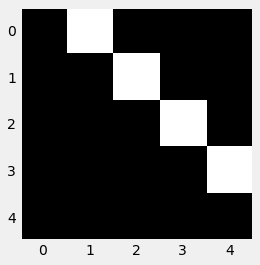

In [14]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

### Transforms on images

In [15]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

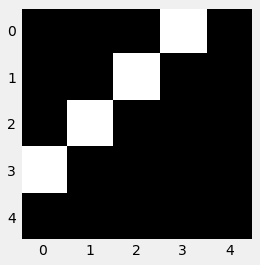

In [17]:
plt.imshow(flipped_img,cmap='gray')
plt.grid(False)

### Transforms on tensors

In [18]:
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [19]:
normalizer = Normalize(mean = (.5,),std = (.5,))
normalized_img = normalizer(img_tensor)
normalized_img

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

### Composing transforms

In [20]:
composer = Compose([RandomHorizontalFlip(p=1.0),Normalize(mean = (.5,),std = (.5,))])

In [21]:
composed_tensor = composer(example_tensor)
composed_tensor == normalized_img

tensor([[[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]]])

In [22]:
example_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [25]:
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

### Data preparation

In [26]:
x_tensor = torch.as_tensor(images/255).float()
y_tensor = torch.as_tensor(labels.reshape(-1,1)).float()

### Dataset Transforms

In [29]:
class TransformedTensorDataset(Dataset):
    def __init__(self,x,y,transform = None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)
        
        return x,self.y[index]
    
    def __len__(self):
        return len(self.x)

In [30]:
composer = Compose([RandomHorizontalFlip(p=0.5),
                    Normalize(mean = (0.5,),std = (0.5,))])

In [31]:
dataset = TransformedTensorDataset(x_tensor,y_tensor,composer)